# Fitting the rat data to the existing model

Find rat data here: https://osf.io/qb3sm/

Original rat data paper: https://www.sciencedirect.com/science/article/pii/0023969071900208

Previous more recent paper that examines rat data: https://link.springer.com/article/10.3758/s13423-020-01801-z#appendices


Sam's paper in Nature that provides the model: https://www.nature.com/articles/s41562-020-00946-0.epdf?sharing_token=wsEbaG-R1RyUegEf6qVJMNRgN0jAjWel9jnR3ZoTv0P7JL9l0iuCFqTGaHEkbCV37dnZvTMe0HitceHpoagy__Z1SgxJ3hquX6Eoy2aNVKrSezA8keumGPHlWYxuZwKUWYe4KKrLS_RD0MIEjXSJgM2QS-gSwVuOwFVLaAQWmt4%3D

In [2]:
from scipy.io import loadmat
rat_one = loadmat('Platt&Johnson1971_rat1.mat')
rat_two = loadmat('Platt&Johnson1971_rat2.mat')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def process_rat(d):
    data = []
    index = list(d.keys())[3:]
    columns = np.arange(1,37)
    for col in index:
        add = 36 - len(d[col][0])
        data += [np.append(d[col][0], [None] * add)]
    return pd.DataFrame(data, columns=columns).set_index(pd.Index(index))

In [5]:
rat_one_df = process_rat(rat_one).T
rat_two_df = process_rat(rat_two).T

In [6]:
rat_one_df.to_csv('rat1.csv')

In [6]:
def LL(CV, CV_pred, n, s):
    return 0.5*np.log(2*np.pi*s**2) + (((CV_pred * n - CV * n) ** 2 )/ (2 * s ** 2) )

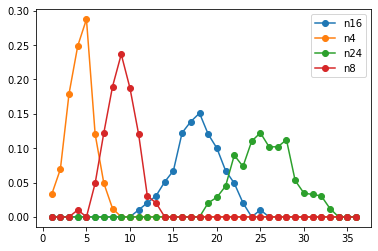

In [7]:
# Response frequency w best fit from MLE estimation
plt.plot(np.arange(1,37), rat_one['n16_y'][0], label = 'n16', marker='o')
plt.plot(np.arange(1,37), rat_one['n4_y'][0], label = 'n4', marker='o')
plt.plot(np.arange(1,37), rat_one['n24_y'][0], label = 'n24', marker='o')
plt.plot(np.arange(1,37), rat_one['n8_y'][0], label = 'n8', marker='o')

plt.legend()
plt.show()

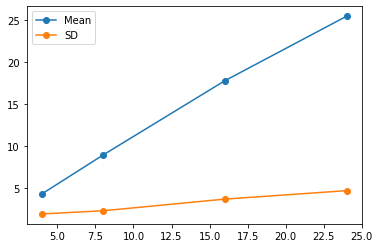

In [8]:
# MLE of Mean and SD
# FIXME: make two axes
plt.plot(rat_one['m_x'][0], rat_one['m_y'][0], label = 'Mean', marker='o')
plt.plot(rat_one['sd_x'][0], rat_one['sd_y'][0], label = 'SD', marker='o')
plt.legend()
plt.show()

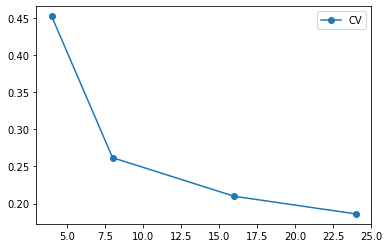

In [96]:
# Resulting coefficients of variation (CV)
# FIXME: figure out flat line
plt.plot(rat_one['cv_x'][0], rat_one['cv_y'][0], label = 'CV', marker='o')
plt.legend()
plt.show()

# Figure 2

In [162]:
rat_one['n4_x'][0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

In [161]:
ns = [4] * 12 + [8]*16 +[16]*17 +[24]*17
p_k = np.concatenate(np.array([rat_one['n4_y'][0],rat_one['n8_y'][0],rat_one['n16_y'][0],rat_one['n24_y'][0]]))
p_n = np.array([1/len(rat_one['n4_x'][0])] * 12 + [1/len(rat_one['n8_x'][0])] * 16 + [1/len(rat_one['n16_x'][0])] * 17 + [1/len(rat_one['n24_x'][0])] * 17)
ks = np.concatenate((rat_one['n4_x'][0],rat_one['n8_x'][0],rat_one['n16_x'][0],rat_one['n24_x'][0]))


lam = find_q_kn(ns,ks,p_n,p_k,1)
# lams = np.ones_like(ns)*0.1
# compute_q_nk(ns, ks, p_n,p_k, lams, sm=1e-10)

ValueError: operands could not be broadcast together with shapes (62,62) (144,) 

In [157]:
lam = np.array([4,6])
lam = lam.reshape((len(lam),1))
p_n = p_n.reshape((len(p_n),1))
# q_nk = -((p_n * (ns-ks)**2.)/(lam))
# q_nk
lam.shape
(p_n * (ns-ks)**2.).shape

(62, 62)

# Fitting models - info bound and prior
From github

In [8]:
import numpy as np
import scipy.stats as st


#def Q(ks,n,p_k,p_n,lam,sm=1e-10):
	#computes the posterior Q for a given lambda
	#q= p_k * np.exp(-(p_n/lam) * (n-ks)**2.)
	#q = (q+sm)/np.sum(q+sm)
	#return q



def KL(p,q):
	#KL divergence with prior p and posterior q
	return np.sum(q * (np.log2(q) - np.log2(p)), axis=1)


def compute_q_nk(ns, ks, p_n,p_k, lam, sm=1e-10):
	#computing the posterior Q for a given lambda
    lam = lam.reshape((len(lam),1))
    p_n = p_n.reshape((len(p_n),1))

    q_nk = -((p_n * (ns-ks)**2.)/(lam)) 


    q_nk = np.exp(q_nk)
    q_nk = q_nk * p_k 
    
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)
    q_nk += sm
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)



    return q_nk


def find_q_nk(ns,ks,p_n,p_k,info_bound, n_steps=1500):
	#uses gradient descent to find lambdas that
	#get KL(Q||P) as close to the bound "info_bound" as possible

    lams = np.ones_like(ns)*0.5
    q_nk = compute_q_nk( ns, ks, p_n,p_k, lams)

    ents = KL(p_k, q_nk)

    for i in range(n_steps):

        diffs = ents - info_bound
        deltas = diffs *0.025

        lams = np.exp(np.log(lams) + deltas.reshape(len(deltas),1))

        q_nk = compute_q_nk(ns,ks,p_n,p_k,lams)
        ents = KL(p_k,q_nk)

    return q_nk





def P(x,a):
	p = 1./(x**a)

	return p/np.sum(p)




import numpy as np
import scipy.stats as st






#def Q(ks,n,p_k,p_n,lam,sm=1e-10):
	#computes the posterior Q for a given lambda
	#q= p_k * np.exp(-(p_n/lam) * (n-ks)**2.)
	#q = (q+sm)/np.sum(q+sm)
	#return q



def KL(p,q):
	#KL divergence with prior p and posterior q
	return np.sum(q * (np.log2(q) - np.log2(p)), axis=1)


def compute_q_nk(ns, ks, p_n,p_k, lam, sm=1e-10):
	#computing the posterior Q for a given lambda
    lam = lam.reshape((len(lam),1))
    p_n = p_n.reshape((len(p_n),1))

    q_nk = -((p_n * (ns-ks)**2.)/(lam)) 


    q_nk = np.exp(q_nk)
    q_nk = q_nk * p_k 
    
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)
    q_nk += sm
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)



    return q_nk


def find_q_nk(ns,ks,p_n,p_k,info_bound, n_steps=1500):
	#uses gradient descent to find lambdas that
	#get KL(Q||P) as close to the bound "info_bound" as possible

    lams = np.ones_like(ns)*0.5
    q_nk = compute_q_nk( ns, ks, p_n,p_k, lams)

    ents = KL(p_k, q_nk)

    for i in range(n_steps):

        diffs = ents - info_bound
        deltas = diffs *0.025

        lams = np.exp(np.log(lams) + deltas.reshape(len(deltas),1))

        q_nk = compute_q_nk(ns,ks,p_n,p_k,lams)
        ents = KL(p_k,q_nk)

    return q_nk





def P(x,a):
	p = 1./(x**a)

	return p/np.sum(p)





## Fitting the info bounds for rat 1&2

### Rat 1

In [ ]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    
    for i in range(0, 21):

        #step_n, step_k give increments
        #which in our model are 1 (natural numbers)
        step_n = 1
        step_k = 1

        #prior parameter, in our paper we use alpha = 2
        alpha = 1

        #range of n and k
        min_n = 1
        max_n = 15
        min_k = step_k
        max_k = 25

    # 	ks = np.arange(min_k,max_k,step_k)
    # 	ns = np.arange(min_n,max_n+1,step_n)
    # 	ns = ns.reshape((len(ns),1))

        ks = np.arange(1,37)
        ns = np.array([4,8,16,24])
        ns = ns.reshape((len(ns),1))

        p_ks = P(ks,float(alpha))
        p_ns = P(ns,float(alpha))

        info_bound = i/5

        Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

        store = [sum(np.log(Q[0]) * rat_one['n4_y'][0] * 400),
                    sum(np.log(Q[1]) * rat_one['n8_y'][0] * 400),
                    sum(np.log(Q[2]) * rat_one['n16_y'][0] * 400),
                    sum(np.log(Q[3]) * rat_one['n24_y'][0] * 400)]
        info_store += [store]
        
        four += [sum(np.log(Q[0]) * rat_one['n4_y'][0] * 400)]
        eight += [sum(np.log(Q[1]) * rat_one['n8_y'][0] * 400)]
        sixteen += [sum(np.log(Q[2]) * rat_one['n16_y'][0] * 400) ]
        tf += [sum(np.log(Q[3]) * rat_one['n24_y'][0] * 400)]
        
#         print(i/5)

# 	print(Q)


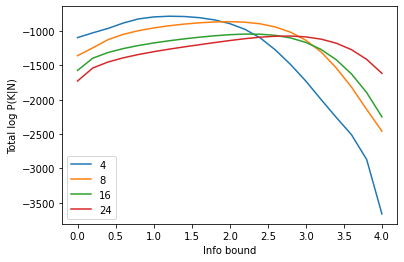

In [14]:
# for i in range(len(info_store)):
info = list(i/5 for i in range(0,21))
plt.plot(info, four, label = '4')
plt.plot(info, eight, label = '8')
plt.plot(info, sixteen, label = '16')
plt.plot(info, tf, label = '24')

plt.xlabel('Info bound')
plt.ylabel('Total log P(K|N)')
plt.legend()
plt.show()

No handles with labels found to put in legend.


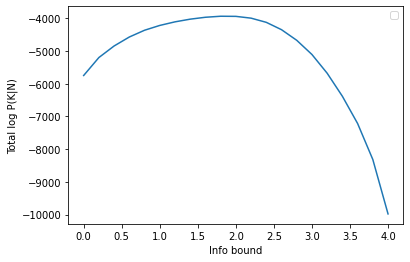

In [15]:
plt.plot(info, [x+y+z+w for x,y,z,w in zip(four,eight,sixteen,tf)])

plt.xlabel('Info bound')
plt.ylabel('Total log P(K|N)')
plt.legend()
plt.show()

### Rat 2

In [16]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    
    for i in range(0, 21):

        #step_n, step_k give increments
        #which in our model are 1 (natural numbers)
        step_n = 1
        step_k = 1

        #prior parameter, in our paper we use alpha = 2
        alpha = 1

        #range of n and k
        min_n = 1
        max_n = 15
        min_k = step_k
        max_k = 25

    # 	ks = np.arange(min_k,max_k,step_k)
    # 	ns = np.arange(min_n,max_n+1,step_n)
    # 	ns = ns.reshape((len(ns),1))

        ks = np.arange(1,37)
        ns = np.array([4,8,16,24])
        ns = ns.reshape((len(ns),1))

        p_ks = P(ks,float(alpha))
        p_ns = P(ns,float(alpha))

        info_bound = i/5

        Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

#         store = [sum(np.log(Q[0]) * rat_one['n4_y'][0] * 400),
#                     sum(np.log(Q[1]) * rat_one['n8_y'][0] * 400),
#                     sum(np.log(Q[2]) * rat_one['n16_y'][0] * 400),
#                     sum(np.log(Q[3]) * rat_one['n24_y'][0] * 400)]
#         info_store += [store]
        
        four += [sum(np.log(Q[0]) * rat_two['n4_y'][0] * 400)]
        eight += [sum(np.log(Q[1]) * rat_two['n8_y'][0] * 400)]
        sixteen += [sum(np.log(Q[2]) * rat_two['n16_y'][0] * 400)]
        tf += [sum(np.log(Q[3]) * rat_two['n24_y'][0] * 400)]
        
#         print(i/5)

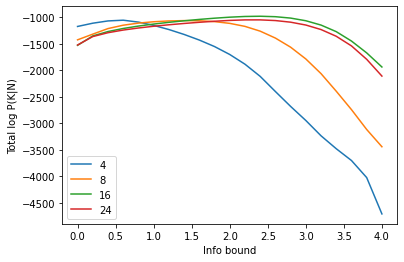

In [17]:
info = list(i/5 for i in range(0,21))
plt.plot(info, four, label = '4')
plt.plot(info, eight, label = '8')
plt.plot(info, sixteen, label = '16')
plt.plot(info, tf, label = '24')

plt.xlabel('Info bound')
plt.ylabel('Total log P(K|N)')
plt.legend()
plt.show()

No handles with labels found to put in legend.


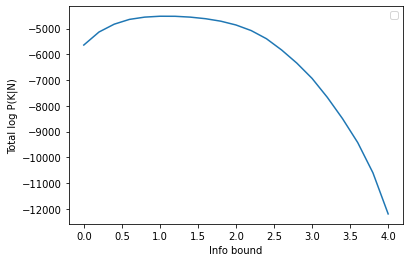

In [18]:
plt.plot(info, [x+y+z+w for x,y,z,w in zip(four,eight,sixteen,tf)])

plt.xlabel('Info bound')
plt.ylabel('Total log P(K|N)')
plt.legend()
plt.show()

## Final fit after fitting just the info bound

### Rat 1

In [36]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    

    #step_n, step_k give increments
    #which in our model are 1 (natural numbers)
    step_n = 1
    step_k = 1

    #prior parameter, in our paper we use alpha = 2
    alpha = 1

    #range of n and k
    min_n = 1
    max_n = 15
    min_k = step_k
    max_k = 25

# 	ks = np.arange(min_k,max_k,step_k)
# 	ns = np.arange(min_n,max_n+1,step_n)
# 	ns = ns.reshape((len(ns),1))

    ks = np.arange(1,37)
    ns = np.array([4,8,16,24])
    ns = ns.reshape((len(ns),1))

    p_ks = P(ks,float(alpha))
    p_ns = P(ns,float(alpha))

    info_bound = 1.75

    Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

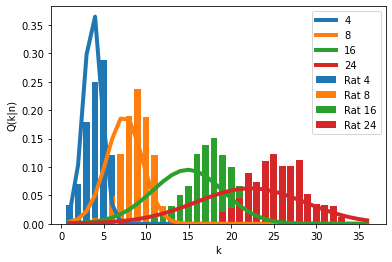

In [38]:
plt.plot(np.arange(1,37), Q[0], label = '4', linewidth=4)
plt.plot(np.arange(1,37), Q[1], label = '8', linewidth=4)
plt.plot(np.arange(1,37), Q[2], label = '16', linewidth=4)
plt.plot(np.arange(1,37), Q[3], label = '24', linewidth=4)

# rat data

plt.bar(np.arange(1,37), rat_one['n4_y'][0], label = 'Rat 4')
plt.bar(np.arange(1,37), rat_one['n8_y'][0], label = 'Rat 8')
plt.bar(np.arange(1,37), rat_one['n16_y'][0], label = 'Rat 16')
plt.bar(np.arange(1,37), rat_one['n24_y'][0], label = 'Rat 24')





plt.xlabel('k')
plt.ylabel('Q(k|n)')
plt.legend()
plt.show()

### Rat 2

In [21]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    

    #step_n, step_k give increments
    #which in our model are 1 (natural numbers)
    step_n = 1
    step_k = 1

    #prior parameter, in our paper we use alpha = 2
    alpha = 1

    #range of n and k
    min_n = 1
    max_n = 15
    min_k = step_k
    max_k = 25

# 	ks = np.arange(min_k,max_k,step_k)
# 	ns = np.arange(min_n,max_n+1,step_n)
# 	ns = ns.reshape((len(ns),1))

    ks = np.arange(1,37)
    ns = np.array([4,8,16,24])
    ns = ns.reshape((len(ns),1))

    p_ks = P(ks,float(alpha))
    p_ns = P(ns,float(alpha))

    info_bound = 1.2

    Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

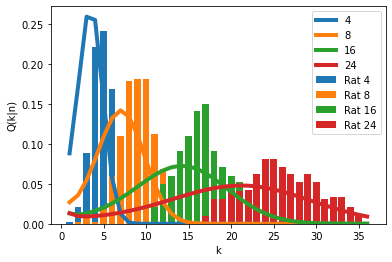

In [25]:
plt.plot(np.arange(1,37), Q[0], label = '4', linewidth=4)
plt.plot(np.arange(1,37), Q[1], label = '8', linewidth=4)
plt.plot(np.arange(1,37), Q[2], label = '16', linewidth=4)
plt.plot(np.arange(1,37), Q[3], label = '24', linewidth=4)

plt.bar(np.arange(1,37), rat_two['n4_y'][0], label = 'Rat 4')
plt.bar(np.arange(1,37), rat_two['n8_y'][0], label = 'Rat 8')
plt.bar(np.arange(1,37), rat_two['n16_y'][0], label = 'Rat 16')
plt.bar(np.arange(1,37), rat_two['n24_y'][0], label = 'Rat 24')

plt.xlabel('k')
plt.ylabel('Q(k|n)')
plt.legend()
plt.show()

## Fitting the prior

### Rat 1

In [58]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    
    for i in range(0, 21):

        #step_n, step_k give increments
        #which in our model are 1 (natural numbers)
        step_n = 1
        step_k = 1

        #prior parameter, in our paper we use alpha = 2
        alpha = i/5

        #range of n and k
        min_n = 1
        max_n = 15
        min_k = step_k
        max_k = 25

    # 	ks = np.arange(min_k,max_k,step_k)
    # 	ns = np.arange(min_n,max_n+1,step_n)
    # 	ns = ns.reshape((len(ns),1))

        ks = np.arange(1,37)
        ns = np.array([4,8,16,24])
        ns = ns.reshape((len(ns),1))

        p_ks = P(ks,float(alpha))
        p_ns = P(ns,float(alpha))

        info_bound = 1.75

        Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

        store = [sum(np.log(Q[0]) * rat_one['n4_y'][0] * 400),
                    sum(np.log(Q[1]) * rat_one['n8_y'][0] * 400),
                    sum(np.log(Q[2]) * rat_one['n16_y'][0] * 400),
                    sum(np.log(Q[3]) * rat_one['n24_y'][0] * 400)]
        info_store += [store]
        
        four += [sum(np.log(Q[0]) * rat_one['n4_y'][0] * 400)]
        eight += [sum(np.log(Q[1]) * rat_one['n8_y'][0] * 400)]
        sixteen += [sum(np.log(Q[2]) * rat_one['n16_y'][0] * 400) ]
        tf += [sum(np.log(Q[3]) * rat_one['n24_y'][0] * 400)]
        


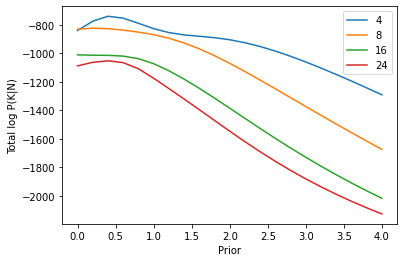

In [59]:
# for i in range(len(info_store)):
info = list(i/5 for i in range(0,21))
plt.plot(info, four, label = '4')
plt.plot(info, eight, label = '8')
plt.plot(info, sixteen, label = '16')
plt.plot(info, tf, label = '24')

plt.xlabel('Prior')
plt.ylabel('Total log P(K|N)')
plt.legend()
plt.show()

No handles with labels found to put in legend.


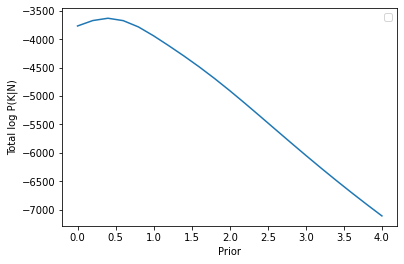

In [53]:
plt.plot(info, [x+y+z+w for x,y,z,w in zip(four,eight,sixteen,tf)])

plt.xlabel('Prior')
plt.ylabel('Total log P(K|N)')
plt.legend()
plt.show()

### Rat 2

In [54]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    
    for i in range(0, 21):

        #step_n, step_k give increments
        #which in our model are 1 (natural numbers)
        step_n = 1
        step_k = 1

        #prior parameter, in our paper we use alpha = 2
        alpha = i/5

        #range of n and k
        min_n = 1
        max_n = 15
        min_k = step_k
        max_k = 25

        ks = np.arange(1,37)
        ns = np.array([4,8,16,24])
        ns = ns.reshape((len(ns),1))

        p_ks = P(ks,float(alpha))
        p_ns = P(ns,float(alpha))

        info_bound = 1.2

        Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

        
        four += [sum(np.log(Q[0]) * rat_two['n4_y'][0] * 400)]
        eight += [sum(np.log(Q[1]) * rat_two['n8_y'][0] * 400)]
        sixteen += [sum(np.log(Q[2]) * rat_two['n16_y'][0] * 400)]
        tf += [sum(np.log(Q[3]) * rat_two['n24_y'][0] * 400)]
        


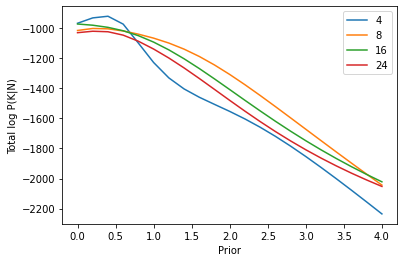

In [55]:
# for i in range(len(info_store)):
info = list(i/5 for i in range(0,21))
plt.plot(info, four, label = '4')
plt.plot(info, eight, label = '8')
plt.plot(info, sixteen, label = '16')
plt.plot(info, tf, label = '24')

plt.xlabel('Prior')
plt.ylabel('Total log P(K|N)')
plt.legend()
plt.show()

No handles with labels found to put in legend.


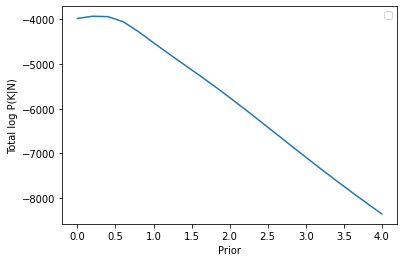

In [56]:
plt.plot(info, [x+y+z+w for x,y,z,w in zip(four,eight,sixteen,tf)])

plt.xlabel('Prior')
plt.ylabel('Total log P(K|N)')
plt.legend()
plt.show()

## Final fit after prior and info bound

### Rat 1

In [60]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    

    #step_n, step_k give increments
    #which in our model are 1 (natural numbers)
    step_n = 1
    step_k = 1

    #prior parameter, in our paper we use alpha = 2
    alpha = 0.4

    #range of n and k
    min_n = 1
    max_n = 15
    min_k = step_k
    max_k = 25

# 	ks = np.arange(min_k,max_k,step_k)
# 	ns = np.arange(min_n,max_n+1,step_n)
# 	ns = ns.reshape((len(ns),1))

    ks = np.arange(1,37)
    ns = np.array([4,8,16,24])
    ns = ns.reshape((len(ns),1))

    p_ks = P(ks,float(alpha))
    p_ns = P(ns,float(alpha))

    info_bound = 1.75

    Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

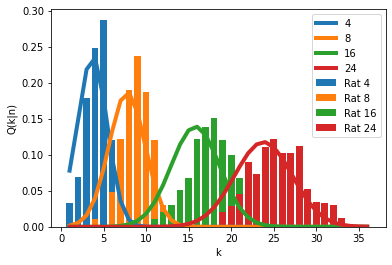

In [61]:
plt.plot(np.arange(1,37), Q[0], label = '4', linewidth=4)
plt.plot(np.arange(1,37), Q[1], label = '8', linewidth=4)
plt.plot(np.arange(1,37), Q[2], label = '16', linewidth=4)
plt.plot(np.arange(1,37), Q[3], label = '24', linewidth=4)

# rat data

plt.bar(np.arange(1,37), rat_one['n4_y'][0], label = 'Rat 4')
plt.bar(np.arange(1,37), rat_one['n8_y'][0], label = 'Rat 8')
plt.bar(np.arange(1,37), rat_one['n16_y'][0], label = 'Rat 16')
plt.bar(np.arange(1,37), rat_one['n24_y'][0], label = 'Rat 24')





plt.xlabel('k')
plt.ylabel('Q(k|n)')
plt.legend()
plt.show()

### Rat 2

In [62]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    

    #step_n, step_k give increments
    #which in our model are 1 (natural numbers)
    step_n = 1
    step_k = 1

    #prior parameter, in our paper we use alpha = 2
    alpha = 0.5

    #range of n and k
    min_n = 1
    max_n = 15
    min_k = step_k
    max_k = 25

# 	ks = np.arange(min_k,max_k,step_k)
# 	ns = np.arange(min_n,max_n+1,step_n)
# 	ns = ns.reshape((len(ns),1))

    ks = np.arange(1,37)
    ns = np.array([4,8,16,24])
    ns = ns.reshape((len(ns),1))

    p_ks = P(ks,float(alpha))
    p_ns = P(ns,float(alpha))

    info_bound = 1.2

    Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

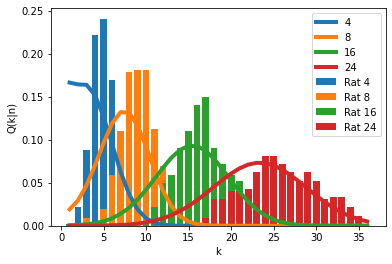

In [64]:
plt.plot(np.arange(1,37), Q[0], label = '4', linewidth=4)
plt.plot(np.arange(1,37), Q[1], label = '8', linewidth=4)
plt.plot(np.arange(1,37), Q[2], label = '16', linewidth=4)
plt.plot(np.arange(1,37), Q[3], label = '24', linewidth=4)

plt.bar(np.arange(1,37), rat_two['n4_y'][0], label = 'Rat 4')
plt.bar(np.arange(1,37), rat_two['n8_y'][0], label = 'Rat 8')
plt.bar(np.arange(1,37), rat_two['n16_y'][0], label = 'Rat 16')
plt.bar(np.arange(1,37), rat_two['n24_y'][0], label = 'Rat 24')

plt.xlabel('k')
plt.ylabel('Q(k|n)')
plt.legend()
plt.show()

# New Model #1 - fitting the policy

Rat 1

In [60]:
if __name__ == "__main__":
    
    info_store = []
    four = []
    eight = []
    sixteen = []
    tf = []
    

    #step_n, step_k give increments
    #which in our model are 1 (natural numbers)
    step_n = 1
    step_k = 1

    #prior parameter, in our paper we use alpha = 2
    alpha = 0.4

    #range of n and k
    min_n = 1
    max_n = 15
    min_k = step_k
    max_k = 25

# 	ks = np.arange(min_k,max_k,step_k)
# 	ns = np.arange(min_n,max_n+1,step_n)
# 	ns = ns.reshape((len(ns),1))

    ks = np.arange(1,37)
    ns = np.array([4,8,16,24])
    ns = ns.reshape((len(ns),1))

    p_ks = P(ks,float(alpha))
    p_ns = P(ns,float(alpha))

    info_bound = 1.75

    Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

In [10]:
rat_one['n4_y'][0] * 400

array([ 13.056,  27.744,  71.808,  99.552, 115.056,  48.144,  19.584,
         4.896,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ])

In [7]:
# Fit policy
k_b, n, k_t = 0,0,0
while True:
    if k_b >= n:
        if k_t >= n:
            print('reward')
        else:
            print('loss')
        break
    else:
        if k_t >= n:
            print('cost')

        continue



SyntaxError: invalid syntax (<ipython-input-7-b0b55dca67a3>, line 3)

# Appendix

In [283]:
import numpy as np
import scipy.stats as st


#def Q(ks,n,p_k,p_n,lam,sm=1e-10):
	#computes the posterior Q for a given lambda
	#q= p_k * np.exp(-(p_n/lam) * (n-ks)**2.)
	#q = (q+sm)/np.sum(q+sm)
	#return q



def KL(p,q):
	#KL divergence with prior p and posterior q
	return np.sum(q * (np.log2(q) - np.log2(p)), axis=1)


def compute_q_nk(ns, ks, p_n,p_k, lam, sm=1e-10):
	#computing the posterior Q for a given lambda
    lam = lam.reshape((len(lam),1))
    p_n = p_n.reshape((len(p_n),1))

    q_nk = -((p_n * (ns-ks)**2.)/(lam)) 


    q_nk = np.exp(q_nk)
    q_nk = q_nk * p_k 
    
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)
    q_nk += sm
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)



    return q_nk


def find_q_nk(ns,ks,p_n,p_k,info_bound, n_steps=1500):
	#uses gradient descent to find lambdas that
	#get KL(Q||P) as close to the bound "info_bound" as possible

    lams = np.ones_like(ns)*0.5
    q_nk = compute_q_nk( ns, ks, p_n,p_k, lams)

    ents = KL(p_k, q_nk)

    for i in range(n_steps):

        diffs = ents - info_bound
        deltas = diffs *0.025

        lams = np.exp(np.log(lams) + deltas.reshape(len(deltas),1))

        q_nk = compute_q_nk(ns,ks,p_n,p_k,lams)
        ents = KL(p_k,q_nk)

    return q_nk





def P(x,a):
	p = 1./(x**a)

	return p/np.sum(p)




import numpy as np
import scipy.stats as st






#def Q(ks,n,p_k,p_n,lam,sm=1e-10):
	#computes the posterior Q for a given lambda
	#q= p_k * np.exp(-(p_n/lam) * (n-ks)**2.)
	#q = (q+sm)/np.sum(q+sm)
	#return q



def KL(p,q):
	#KL divergence with prior p and posterior q
	return np.sum(q * (np.log2(q) - np.log2(p)), axis=1)


def compute_q_nk(ns, ks, p_n,p_k, lam, sm=1e-10):
	#computing the posterior Q for a given lambda
    lam = lam.reshape((len(lam),1))
    p_n = p_n.reshape((len(p_n),1))

    q_nk = -((p_n * (ns-ks)**2.)/(lam)) 


    q_nk = np.exp(q_nk)
    q_nk = q_nk * p_k 
    
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)
    q_nk += sm
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)



    return q_nk


def find_q_nk(ns,ks,p_n,p_k,info_bound, n_steps=1500):
	#uses gradient descent to find lambdas that
	#get KL(Q||P) as close to the bound "info_bound" as possible

    lams = np.ones_like(ns)*0.5
    q_nk = compute_q_nk( ns, ks, p_n,p_k, lams)

    ents = KL(p_k, q_nk)

    for i in range(n_steps):

        diffs = ents - info_bound
        deltas = diffs *0.025

        lams = np.exp(np.log(lams) + deltas.reshape(len(deltas),1))

        q_nk = compute_q_nk(ns,ks,p_n,p_k,lams)
        ents = KL(p_k,q_nk)

    return q_nk

if __name__ == "__main__":

    p_info = []

    for i in range(1, 11):
        #step_n, step_k give increments
        #which in our model are 1 (natural numbers)
        step_n = 1
        step_k = 1

        #prior parameter, in our paper we use alpha = 2
        alpha = 1

        #range of n and k
        min_n = 1
        max_n = 15
        min_k = step_k
        max_k = 25

    # 	ks = np.arange(min_k,max_k,step_k)
    # 	ns = np.arange(min_n,max_n+1,step_n)
    # 	ns = ns.reshape((len(ns),1))

        ks = np.arange(1,37)
        ns = np.array([4,8,16,24])
        ns = ns.reshape((len(ns),1))

    # 	p_ks = P(ks,float(alpha))
        p_ks = [rat_one['n4_y'][0], rat_one['n8_y'][0], rat_one['n16_y'][0], rat_one['n24_y'][0]]
        p_ns = P(ns,float(alpha))

        info_bound = i

        Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

    # 	print(Q)

        store = []
        for p in Q:
            store += [sum(np.log(p))]
        
        print(info_bound, store)
        
#         p_info += [store]


/Users/catherinewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log2


1 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
2 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
3 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
4 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
5 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
6 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
7 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
8 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
9 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]
10 [-664.7026515399948, -645.3708538065517, -548.1976621795359, -527.3137821551957]


In [295]:
if __name__ == "__main__":

	#step_n, step_k give increments
	#which in our model are 1 (natural numbers)
	step_n = 1
	step_k = 1

	#prior parameter, in our paper we use alpha = 2
	alpha = 1

	#range of n and k
	min_n = 1
	max_n = 15
	min_k = step_k
	max_k = 25

# 	ks = np.arange(min_k,max_k,step_k)
# 	ns = np.arange(min_n,max_n+1,step_n)
# 	ns = ns.reshape((len(ns),1))

	ks = np.arange(1,37)
	ns = np.array([4,8,16,24])
	ns = ns.reshape((len(ns),1))

	p_ks = [rat_one['n4_y'][0], rat_one['n8_y'][0], rat_one['n16_y'][0], rat_one['n24_y'][0]]
	p_ns = P(ns,float(alpha))

	info_bound = 3

	Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

# 	print(Q)


/Users/catherinewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log2


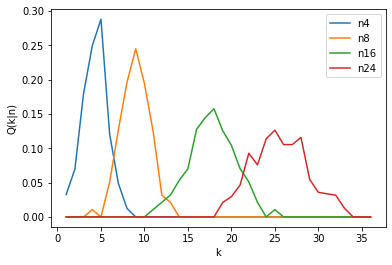

In [296]:
actual_p = Q
plt.plot(np.arange(1,37), Q[0], label = 'n4')
plt.plot(np.arange(1,37), Q[1], label = 'n8')
plt.plot(np.arange(1,37), Q[2], label = 'n16')
plt.plot(np.arange(1,37), Q[3], label = 'n24')

plt.xlabel('k')
plt.ylabel('Q(k|n)')
plt.legend()
plt.show()

In [297]:
actual_p

array([[3.26530612e-02, 6.93877550e-02, 1.79591836e-01, 2.48979591e-01,
        2.87755101e-01, 1.20408163e-01, 4.89795918e-02, 1.22448980e-02,
        9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 9.99999996e-11,
        9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 9.99999996e-11,
        9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 9.99999996e-11,
        9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 9.99999996e-11,
        9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 9.99999996e-11,
        9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 9.99999996e-11,
        9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 9.99999996e-11],
       [9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 1.05485233e-02,
        9.99999996e-11, 5.06329113e-02, 1.26582278e-01, 1.96202531e-01,
        2.44725738e-01, 1.94092826e-01, 1.24472573e-01, 3.16455696e-02,
        2.10970464e-02, 9.99999996e-11, 9.99999996e-11, 9.99999996e-11,
        9.99999996e-11, 9.99999996e-11, 9.99999996e-11, 9.99999

In [302]:

sum(np.log(model_p[0]) * rat_one['n4_y'][0] * 400)

-1726.8172788325573

In [246]:
import random
import scipy.stats as st
import copy


def get_data(file):
    df = pd.read_csv(file)
    grouped = df.groupby("uniqueid")
    n_shown,n_guess,info = [],[],[]

    for subj,row in grouped:
        n_shown.append(list(row["n_shown"]))
        n_guess.append(list(row["n_guess"]))
        if "dur" in file:
            #convert to milliseconds
            info.append(list(row["exp_dur"]/1000.))
        else:
            #convert opacity to contrast
            info.append(list(row["opacity"]*2.5))

    a = lambda x: np.array(x)
    return a(n_shown), a(n_guess), a(info)


def approx_weber_ll(n,g,sd):

    #get the area under the curve around n
    cdf_high = st.norm.cdf(g+0.5,n,sd) 
    cdf_low = st.norm.cdf(g-0.5,n,sd)

    p = np.log(cdf_high - cdf_low + 1e-10)

    p = p.sum(axis=1).reshape((len(p),1))

    return p



def accept(curr,prop):
    #metropolis-hastings acceptance 
    if prop > curr:
        return True
    else:
        ratio = np.exp(prop-curr)

        if ratio > random.random():
            return True
        else:
            return False
        
        
def compute_q_nk(ns, ks, p_n,p_k, lam, sm=1e-10):
    #compute Q(k|n) given numbers n, estimates k
    #priors p_n/p_k and a lambda parameter (from info bound)
    lam = lam.reshape((len(lam),1))
    p_n = p_n.reshape((len(p_n) * 36,1))

    q_nk = -((p_n * (ns-ks)**2.)/(lam)) 
    q_nk = np.exp(q_nk)
    q_nk = q_nk * p_k 
    
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)
    
    q_nk += sm
    
    q_nk = (q_nk)/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)

    return q_nk

def find_q_kn(ns,ks,p_n,p_k,info, n_steps=1000):
    #finds lambda that constraints Q(k|n)
    #to be closest to the information bound

    lams = np.ones_like(ns)*0.1
    q_nk = compute_q_nk( ns, ks, p_n,p_k, lams)
    ents = np.sum(q_nk * (np.log2(q_nk) - np.log2(p_k)), axis=1)


    for i in range(n_steps):

        diffs = ents - info
        deltas = diffs *0.05

        lams = np.exp(np.log(lams) + deltas.reshape(len(deltas),1))
        q_nk = compute_q_nk(ns,ks,p_n,p_k,lams)
        ents = np.sum(q_nk * (np.log2(q_nk) - np.log2(p_k)), axis=1)


    return q_nk